In [1]:
!date

Mon Mar  2 17:39:22 PST 2020


# Merfish

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from scipy.spatial import ConvexHull
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
clusters = pd.read_csv("../../merfish/cell_labels.csv")
clusters.index = clusters["Unnamed: 0"].values
del clusters["Unnamed: 0"]

In [4]:
adata = anndata.read_h5ad("../../merfish/merfish_M1.h5ad")
tmp = pd.DataFrame({col: adata.obs.index.map(clusters[col]) for col in clusters})
adata.obs = tmp

In [5]:
adata.layers["X"] = csr_matrix(adata.X)
adata.layers["norm"] = normalize(adata.X, norm='l1', axis=1)*1000000
adata.layers["log1p"] = csr_matrix(np.log1p(adata.layers["norm"]))

In [6]:
from sklearn.preprocessing import scale

In [7]:
%%time
mat = adata.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
adata.X = mtx

CPU times: user 1.76 s, sys: 799 ms, total: 2.56 s
Wall time: 2.55 s


In [8]:
adata

AnnData object with n_obs × n_vars = 243799 × 254 
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)'
    layers: 'X', 'norm', 'log1p'

In [9]:
adata.obs.head()

label     subclass          sampleID            sliceID label_v1  \
0      Sst_1          Sst  dataset2_sample6  dataset2_slice109      I30   
1       Endo  Endothelial  dataset1_sample1   dataset1_slice50     Endo   
2    L6_IT_1        L6_IT  dataset2_sample3  dataset2_slice139       E8   
3  L2/3_IT_3      L2/3_IT  dataset2_sample1   dataset2_slice61       E2   
4       VLMC         VLMC  dataset1_sample5  dataset1_slice260     VLMC   

   AP_distance (um)   pos_x (um)   pos_y (um)  
0              1180   -79.474594  2211.467867  
1               490  3837.284502 -3847.753461  
2              1480  3502.243851 -3511.940334  
3               700 -3975.718063 -2609.660891  
4              2590 -6370.114257   623.408623

In [10]:
gb = adata.obs.groupby("sliceID")["pos_x (um)", "pos_y (um)"]

In [11]:
adata.shape

(243799, 254)

In [12]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)

In [13]:
c = t2g.groupby("gene_name")["transcript_id"].nunique()

In [14]:
adata.var["n_iso"] = adata.var.index.map(c)

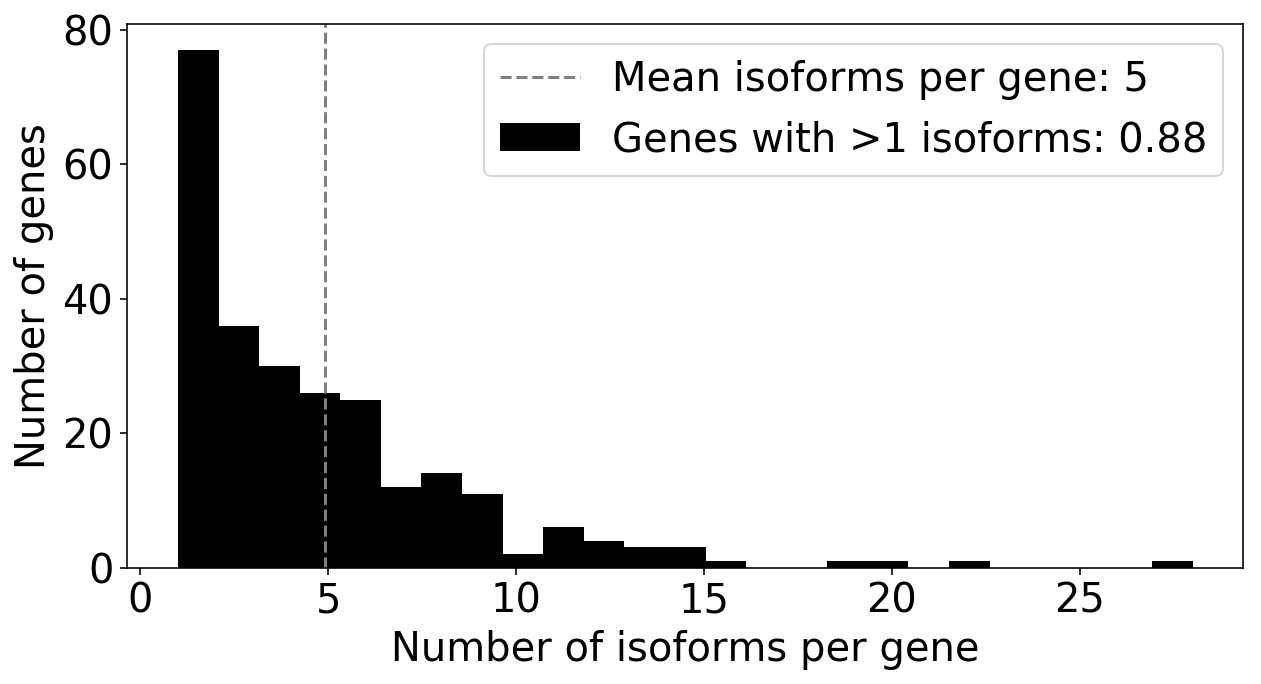

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
x = adata.var["n_iso"].values
ax.hist(x, bins=25, color="k", label="Genes with >1 isoforms: {:,.2f}".format((x>1).sum()/x.shape[0]))

ax.set_xlabel("Number of isoforms per gene")
ax.set_ylabel("Number of genes")

ax.axvline(x.mean(), color="grey", linestyle="--", label="Mean isoforms per gene: {:,.0f}".format(x.mean()))

ax.legend()
plt.savefig("./figures/merfish_isoform_distribution.png", bbox_inches='tight', dpi=300)

plt.show()

In [16]:
gene = "Pvalb"

In [17]:
gene in adata.var.index.values

True

In [18]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [19]:
sliceID = adata.obs.sliceID.values
sliceID = np.unique(sliceID)

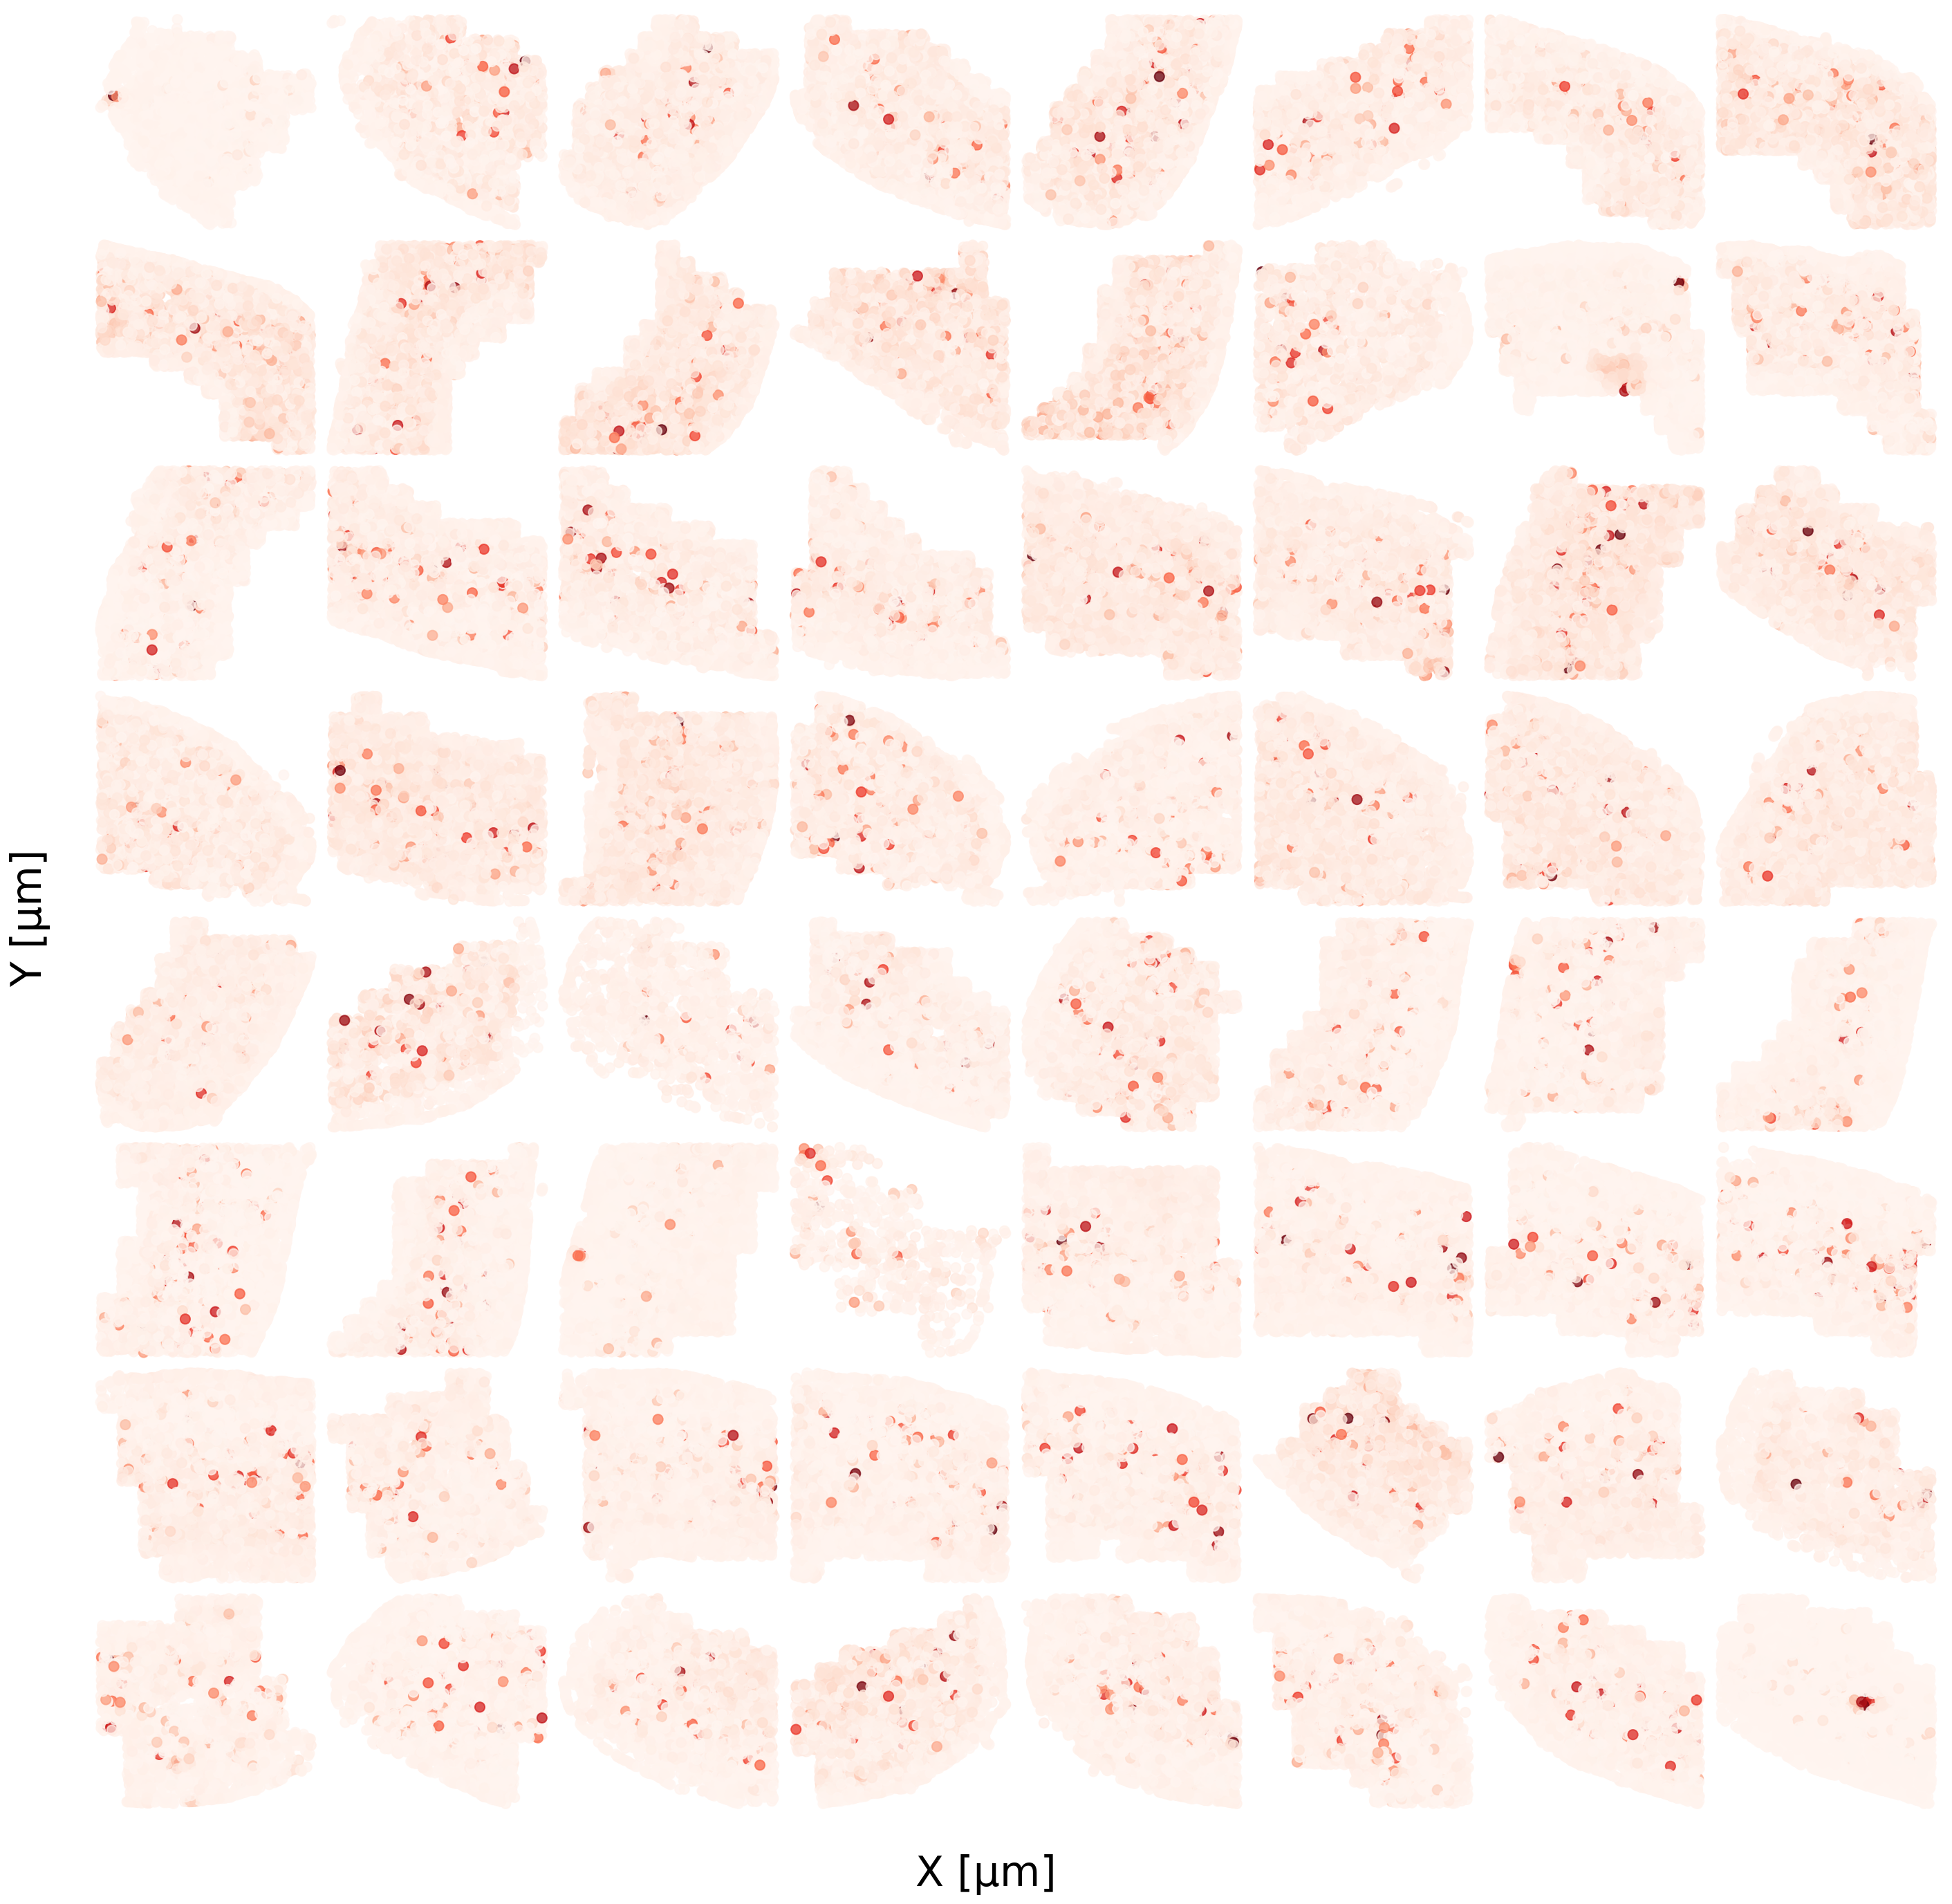

CPU times: user 1min 14s, sys: 4.99 s, total: 1min 19s
Wall time: 1min 11s


In [20]:
%%time
fig, ax = plt.subplots(figsize=(24,24), ncols=8, nrows=8)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(sliceID))

gene_vec = adata.layers["X"].todense()[:,adata.var.index == gene]


for sidx, (ax, slice_name) in enumerate(zip(axs, sliceID)):

    s = gb.get_group(sliceID[sidx])
    
    X_mask = s.index.values
    
    x = adata.obs["pos_x (um)"][X_mask]
    y = adata.obs["pos_y (um)"][X_mask]
    
    # points = np.array([x.tolist(), y.tolist()]).T
    # hull = ConvexHull(points)
    
    c = np.asarray(gene_vec[X_mask]).reshape(-1)
    
    ax.scatter(x, y, c=c, cmap="Reds", label=slice_name, s=50, alpha=0.75)
    
    # x = points[hull.vertices,0].tolist() + [points[hull.vertices,0].tolist()[0]]
    # y = points[hull.vertices,1].tolist() + [points[hull.vertices,1].tolist()[0]]
    # ax.plot(x, y, color="grey")
    ax.set_xlabel("X [µm]")
    ax.set_ylabel("y [µm]")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()

fig.text(0.5, 0.1, 'X [µm]', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'Y [µm]', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("./figures/merfish_{}.png".format(gene), bbox_inches='tight',dpi=300)
plt.show()

In [21]:
specific_cluster = "Pvalb"

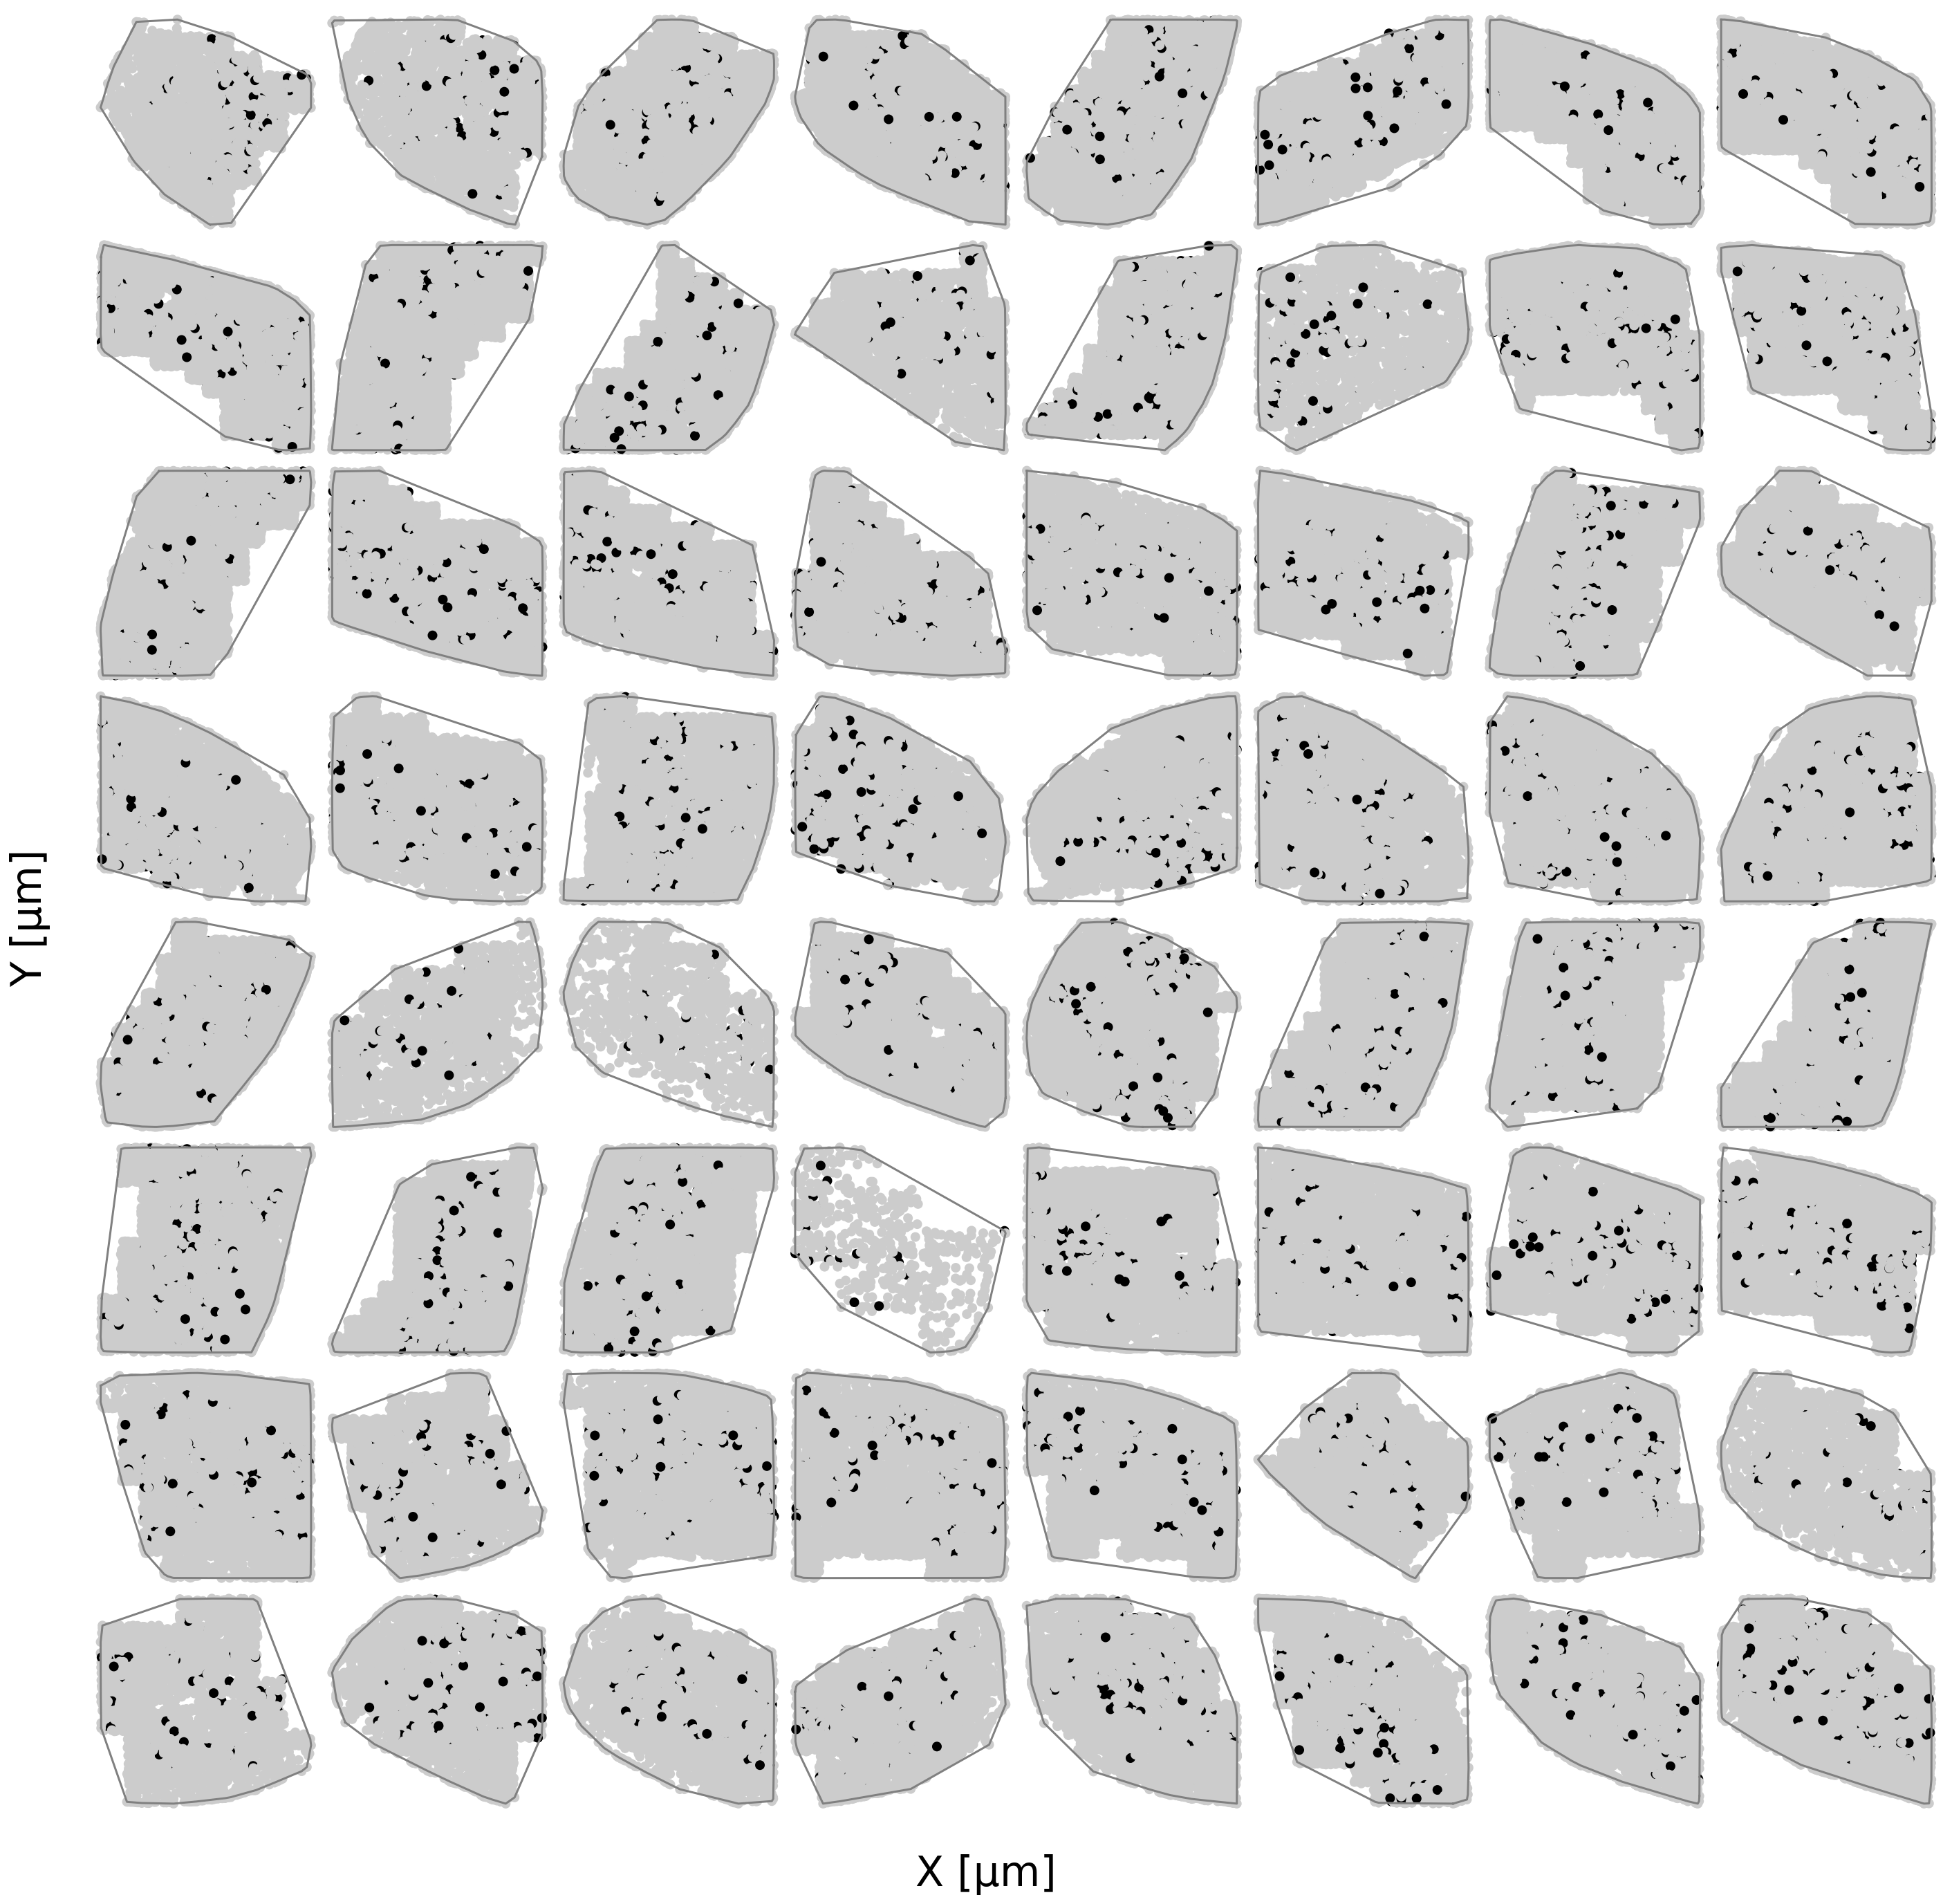

CPU times: user 1min, sys: 4.49 s, total: 1min 4s
Wall time: 57 s


In [22]:
%%time
fig, ax = plt.subplots(figsize=(24,24), ncols=8, nrows=8)
fig.subplots_adjust(hspace=0, wspace=0)

axs = trim_axs(ax, len(sliceID))

#gene_vec = adata.X[:,adata.var.index == gene]
le = LabelEncoder()
subclass_vec = le.fit_transform(adata.obs.subclass.values==specific_cluster)

for sidx, (ax, slice_name) in enumerate(zip(axs, sliceID)):
    s = gb.get_group(sliceID[sidx])
    
    X_mask = s.index.values
    
    x = adata.obs["pos_x (um)"][X_mask]
    y = adata.obs["pos_y (um)"][X_mask]
    c = np.asarray(subclass_vec[X_mask]).reshape(-1)
    
    points = np.array([x.tolist(), y.tolist()]).T
    hull = ConvexHull(points)
    
    ax.scatter(x, y, c=c, cmap="nipy_spectral_r", label=slice_name)

    x = points[hull.vertices,0].tolist() + [points[hull.vertices,0].tolist()[0]]
    y = points[hull.vertices,1].tolist() + [points[hull.vertices,1].tolist()[0]]
    ax.plot(x, y, color="grey")
    
    
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
    
fig.text(0.5, 0.1, 'X [µm]', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'Y [µm]', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("./figures/merfish_cluster_loc_{}.png".format(gene), bbox_inches='tight',dpi=300)
plt.show()

In [23]:
unique = adata.obs.subclass.unique()

In [24]:
unique

array(['Sst', 'Endothelial', 'L6_IT', 'L2/3_IT', 'VLMC', 'L6_CT',
       'L4/5_IT', 'Vip', 'Pvalb', 'Oligodendrocytes', 'Microglia',
       'L5_PT', 'L5_IT', 'Pericytes', 'Astrocytes', 'L56_NP',
       'L6_IT_Car3', 'OPC', 'Lamp5', 'SMC', 'Sncg', 'striatum', 'L6b',
       'Macrophages', 'Sst_Chodl', 'Ependymal'], dtype=object)

In [25]:
specific_gene = "Pvalb"
specific_cluster = "Pvalb"

In [26]:
adata.obs.subclass.unique()

array(['Sst', 'Endothelial', 'L6_IT', 'L2/3_IT', 'VLMC', 'L6_CT',
       'L4/5_IT', 'Vip', 'Pvalb', 'Oligodendrocytes', 'Microglia',
       'L5_PT', 'L5_IT', 'Pericytes', 'Astrocytes', 'L56_NP',
       'L6_IT_Car3', 'OPC', 'Lamp5', 'SMC', 'Sncg', 'striatum', 'L6b',
       'Macrophages', 'Sst_Chodl', 'Ependymal'], dtype=object)

In [106]:
unique_map = {
"L5_IT" : "L5 IT",
"L6_CT" : "L6 CT",
"L6b" : "L6b",
"Vip" : "Vip",
"Pvalb" : "Pvalb",
"L2/3_IT" : "L2/3 IT",
"L6_IT" : "L6 IT",
"Sst" : "Sst",
"Lamp5" : "Lamp5",
"L56_NP" : "L5/6 NP",
"Sncg" : "Sncg",
"SMC" : "SMC",
"L5_PT" : "L5 ET", # Check
"Endothelial" : "Endo",
"Astrocytes" : "Astro",
"VLMC" : "VLMC",
"L6_IT_Car3" : "L6 IT Car3"}

inv_map = {v: k for k, v in unique_map.items()}

In [28]:
specific_gene

'Pvalb'

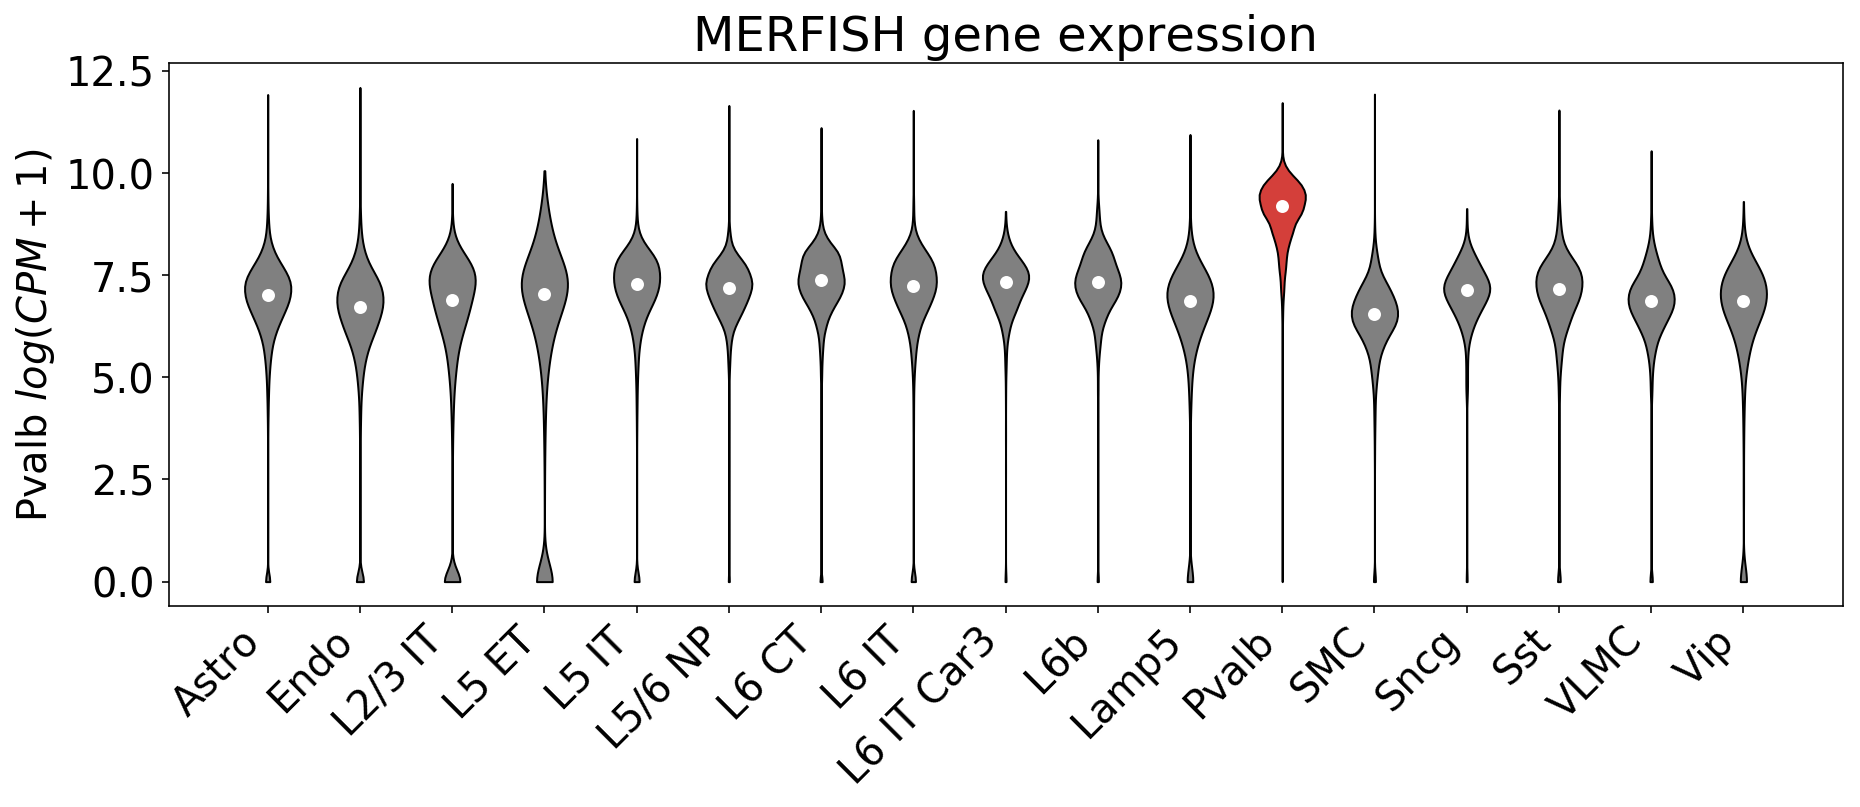

In [29]:
fig, ax = plt.subplots(figsize=(15,5), nrows=1)



unique = np.unique(adata.obs.subclass)
labels = [unique_map.get(i) for i in unique_map.keys()]
labels = np.sort(labels).tolist()
lidx = np.arange(1, len(labels)+1)  # the label locations

tmp_specific_cluster = unique_map[specific_cluster]

midx = labels.index(tmp_specific_cluster)


tmp = adata[:,adata.var.index.values==specific_gene]

x = []
for c in labels:
    tmp_cluster = inv_map[c]
    x.append(np.asarray(tmp[adata.obs.subclass==tmp_cluster].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
#ax.axhline(y=medians[midx], color="k")
ax.set_ylabel("{} $log(CPM + 1)$".format(specific_gene))
ax.set_title("MERFISH gene expression")
plt.savefig("./figures/merfish_violin_{}.png".format(specific_gene), bbox_inches='tight',dpi=300)
plt.show()

In [30]:
adata.obs["cell_id"] = adata.obs.index.values

# Save adata

In [69]:
adata.write("../cell_ranger_annotation/merfish.h5ad")

... storing 'label' as categorical
... storing 'subclass' as categorical
... storing 'sampleID' as categorical
... storing 'sliceID' as categorical
... storing 'label_v1' as categorical


# Cluster comparisons

In [82]:
ss = anndata.read_h5ad("../cell_ranger_annotation/no_filter_gene.h5ad")

In [83]:
print(ss)
print(adata)

AnnData object with n_obs × n_vars = 6295 × 31053 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'X', 'log1p', 'norm'
AnnData object with n_obs × n_vars = 243799 × 254 
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)', 'cell_id'
    var: 'n_iso'
    layers: 'X', 'norm', 'log1p'


In [84]:
ss_genes = ss.var.gene_name.str.split("_").apply(lambda x: x[0]).values
adata_genes = adata.var.index.values

In [85]:
common_genes = np.intersect1d(ss_genes, adata_genes)

In [86]:
ss.var["gene_name_only"] = ss.var.gene_name.str.split("_").apply(lambda x: x[0]).values

In [87]:
mfish = adata[:,adata.var.index.isin(common_genes)]
ss = ss[:,ss.var.gene_name_only.isin(common_genes)]

# Process

In [88]:
from sklearn.preprocessing import normalize

In [90]:
ss.layers["norm"] = normalize(ss.layers["X"], norm='l1', axis=1)*1000000
ss.layers["log1p"] = csr_matrix(np.log1p(ss.layers["norm"]))

In [91]:
from sklearn.preprocessing import scale

In [92]:
%%time
mat = ss.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
ss.X = mtx

CPU times: user 32.9 ms, sys: 26.1 ms, total: 58.9 ms
Wall time: 57.4 ms


In [93]:
print(ss)
print(mfish)

AnnData object with n_obs × n_vars = 6295 × 254 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name_only'
    layers: 'X', 'log1p', 'norm'
View of AnnData object with n_obs × n_vars = 243799 × 254 
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)', 'cell_id'
    var: 'n_iso'
    layers: 'X', 'norm', 'log1p'


In [94]:
mfish.var

n_iso
index               
1700022I11Rik      5
1810046K07Rik      2
5031425F14Rik      1
5730522E02Rik      8
Acta2              1
...              ...
Sst                1
Rab3b              4
Slc17a7            5
Penk               2
Gad1               8

[254 rows x 1 columns]

In [95]:
ss = ss[:,ss.var.sort_values("gene_name_only").index]
mfish = mfish[:,mfish.var.sort_index().index]

In [96]:
ss.var.head()

transcript_id             gene_id  \
1700022I11Rik_ENSMUSG00000028451  ENSMUST00000189414  ENSMUSG00000028451   
1810046K07Rik_ENSMUSG00000036027  ENSMUST00000039959  ENSMUSG00000036027   
5031425F14Rik_ENSMUSG00000085129  ENSMUST00000127920  ENSMUSG00000085129   
5730522E02Rik_ENSMUSG00000032985  ENSMUST00000153834  ENSMUSG00000032985   
Acta2_ENSMUSG00000035783          ENSMUST00000039631  ENSMUSG00000035783   

                                                         gene_name  \
1700022I11Rik_ENSMUSG00000028451  1700022I11Rik_ENSMUSG00000028451   
1810046K07Rik_ENSMUSG00000036027  1810046K07Rik_ENSMUSG00000036027   
5031425F14Rik_ENSMUSG00000085129  5031425F14Rik_ENSMUSG00000085129   
5730522E02Rik_ENSMUSG00000032985  5730522E02Rik_ENSMUSG00000032985   
Acta2_ENSMUSG00000035783                  Acta2_ENSMUSG00000035783   

                                                       transcript_name  \
1700022I11Rik_ENSMUSG00000028451  1700022I11Rik-204_ENSMUST00000189414   
1810046K07Rik_ENSMUSG00000036027  1810046K07Rik-201_ENSMUST00000039959   
5031425F14Rik_ENSMUSG00000085129  5031425F14Rik-201_ENSMUST00000127920   
5730522E02Rik_ENSMUSG00000032985  5730522E02Rik-207_ENSMUST00000153834   
Acta2_ENSMUSG00000035783                  Acta2-201_ENSMUST00000039631   

                                  length  \
1700022I11Rik_ENSMUSG00000028451     518   
1810046K07Rik_ENSMUSG00000036027    1318   
5031425F14Rik_ENSMUSG00000085129    2098   
5730522E02Rik_ENSMUSG00000032985     473   
Acta2_ENSMUSG00000035783            1781   

                                                                           txn_list  \
1700022I11Rik_ENSMUSG00000028451  ['ENSMUST00000189414', 'ENSMUST00000185904', '...   
1810046K07Rik_ENSMUSG00000036027       ['ENSMUST00000039959', 'ENSMUST00000181366']   
5031425F14Rik_ENSMUSG00000085129                             ['ENSMUST00000127920']   
5730522E02Rik_ENSMUSG00000032985  ['ENSMUST00000153834', 'ENSMUST00000144503', '...   
Acta2_ENSMUSG00000035783                                     ['ENSMUST00000039631']   

                                  num_isoforms  gene_counts  dispersion  \
1700022I11Rik_ENSMUSG00000028451             5     0.988477    0.023196   
1810046K07Rik_ENSMUSG00000036027             2     0.179212    0.030656   
5031425F14Rik_ENSMUSG00000085129             1     6.078172    0.094898   
5730522E02Rik_ENSMUSG00000032985             8   126.264420    0.103674   
Acta2_ENSMUSG00000035783                     1   129.483337   13.230916   

                                  pass_disp_filter  highly_variable     means  \
1700022I11Rik_ENSMUSG00000028451              True            False  0.108015   
1810046K07Rik_ENSMUSG00000036027              True            False  0.019548   
5031425F14Rik_ENSMUSG00000085129              True             True  0.490065   
5730522E02Rik_ENSMUSG00000032985              True             True  2.784232   
Acta2_ENSMUSG00000035783                      True             True  3.230993   

                                  dispersions  dispersions_norm gene_name_only  
1700022I11Rik_ENSMUSG00000028451     2.785275          0.326415  1700022I11Rik  
1810046K07Rik_ENSMUSG00000036027     2.969544          0.410919  1810046K07Rik  
5031425F14Rik_ENSMUSG00000085129     4.021044          0.893130  5031425F14Rik  
5730522E02Rik_ENSMUSG00000032985     4.220397          1.015788  5730522E02Rik  
Acta2_ENSMUSG00000035783             9.535823          9.322950          Acta2

In [97]:
mfish.var.head()

n_iso
index               
1700022I11Rik      5
1810046K07Rik      2
5031425F14Rik      1
5730522E02Rik      8
Acta2              1

In [98]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [107]:
ss = ss[ss.obs.subclass_label!="Low Quality"]
mfish.obs["ss_subclass"] = mfish.obs["subclass"].apply(lambda x: unique_map.get(x, "None"))
mfish = mfish[mfish.obs.ss_subclass != "None"]

Trying to set attribute `.obs` of view, copying.


In [109]:
mfish_mat = mfish.X
mfish_ass = mfish.obs.ss_subclass.values

In [110]:
ss_mat = ss.X
ss_ass = ss.obs.subclass_label.values

In [111]:
ss

View of AnnData object with n_obs × n_vars = 6283 × 254 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name_only'
    layers: 'X', 'log1p', 'norm'

In [112]:
mfish

View of AnnData object with n_obs × n_vars = 166556 × 254 
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)', 'cell_id', 'ss_subclass'
    var: 'n_iso'
    layers: 'X', 'norm', 'log1p'

In [113]:
features = mfish.var.index.values

unique = np.intersect1d(np.unique(mfish_ass), np.unique(ss_ass))

In [114]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [115]:
from scipy import stats

In [116]:
%%time
r2 = []
ss_x = []
mfish_x = []

for uidx, u in enumerate(unique):
    mfish_t_mat, _ = split_by_target(mfish_mat, mfish_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    
    mf = np.asarray(mfish_t_mat.mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat.mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    mfish_x.append(mf)
    
    r, p = stats.pearsonr(mf, s)
    r2.append(r**2)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r**2, u) )

[1 of 17] 0.31: Astro
[2 of 17] 0.42: Endo
[3 of 17] 0.61: L2/3 IT
[4 of 17] 0.59: L5 ET
[5 of 17] 0.21: L5 IT
[6 of 17] 0.73: L5/6 NP
[7 of 17] 0.65: L6 CT
[8 of 17] 0.64: L6 IT
[9 of 17] 0.54: L6 IT Car3
[10 of 17] 0.77: L6b
[11 of 17] 0.78: Lamp5
[12 of 17] 0.73: Pvalb
[13 of 17] 0.41: SMC
[14 of 17] 0.69: Sncg
[15 of 17] 0.67: Sst
[16 of 17] 0.47: VLMC
[17 of 17] 0.64: Vip
CPU times: user 645 ms, sys: 606 ms, total: 1.25 s
Wall time: 1.24 s


In [117]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
#"Astro" : (0.9019607843137255,  0.3333333333333333,  0.050980392156862744),  # e6550d #reds
#"Endo" : (0.9921568627450981,  0.5529411764705883,  0.23529411764705882 ),  # fd8d3c
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
#"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
#"Low Quality" : (0.5490196078431373,  0.42745098039215684, 0.19215686274509805),  # 8c6d31
#"SMC" : (0.7411764705882353,  0.6196078431372549,  0.2235294117647059 ),  # bd9e39
#"VLMC" : (0.9058823529411765,  0.7294117647058823,  0.3215686274509804 ),  # e7ba52
# (0.9058823529411765,  0.796078431372549,   0.5803921568627451 ),  # e7cb94
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
#"Pvalb" : (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  ),  # 756bb1
#(0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
#"Pvalb":(0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ),  # dadaeb
}

In [118]:
ss_size = ss.obs["subclass_label"].value_counts()[unique]

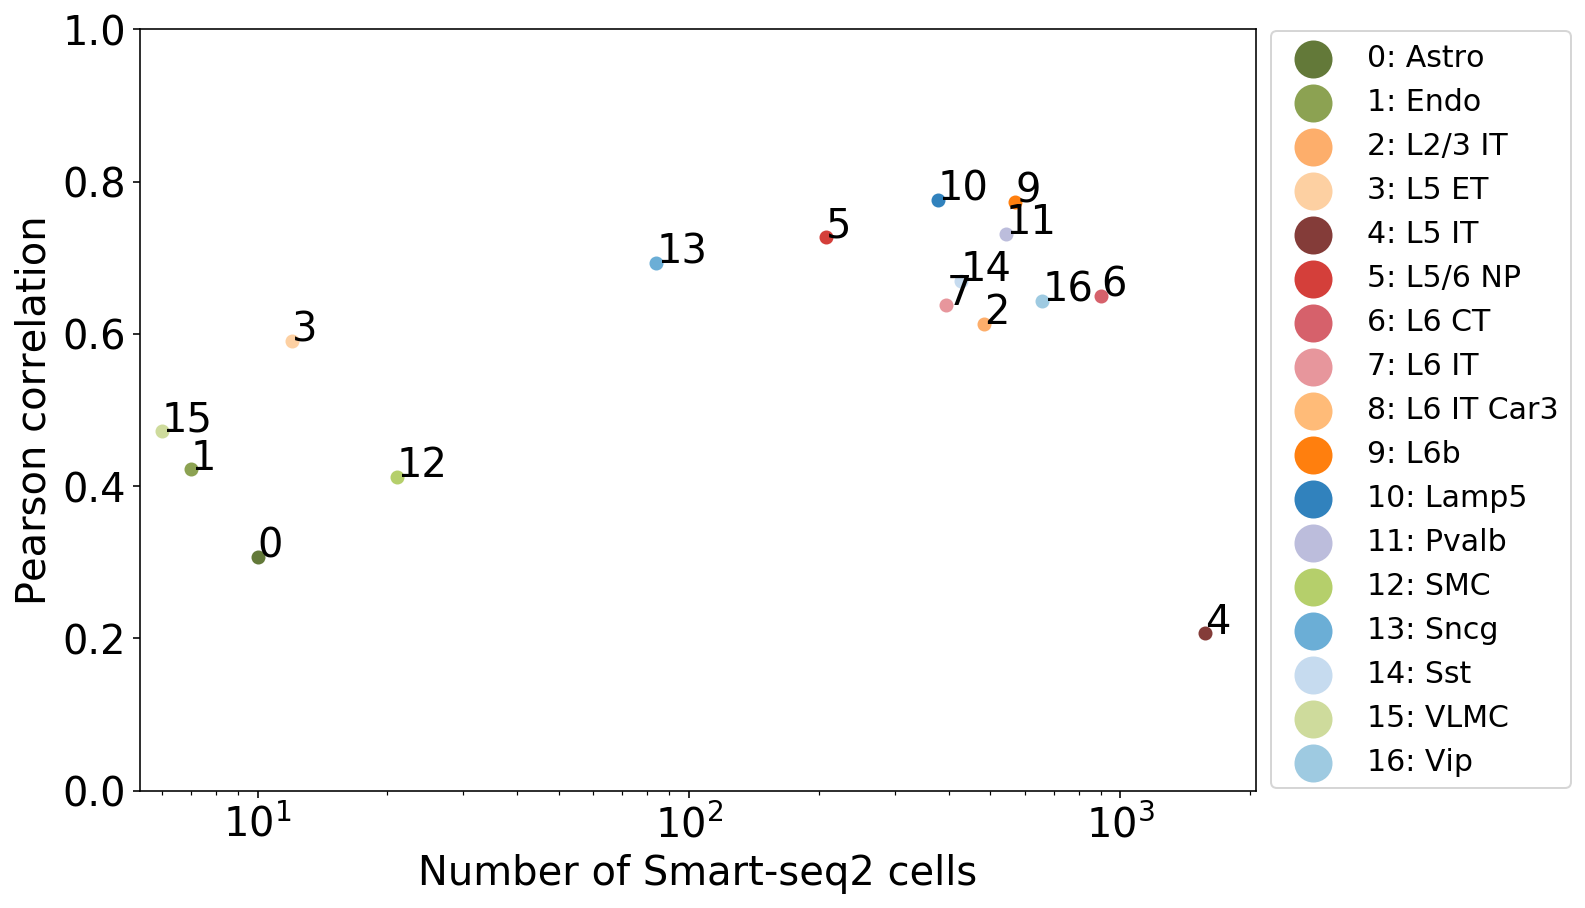

In [121]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smart-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
plt.savefig("./figures/merfish_correlation_size.png", bbox_inches='tight', dpi=300)
plt.show()

In [122]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

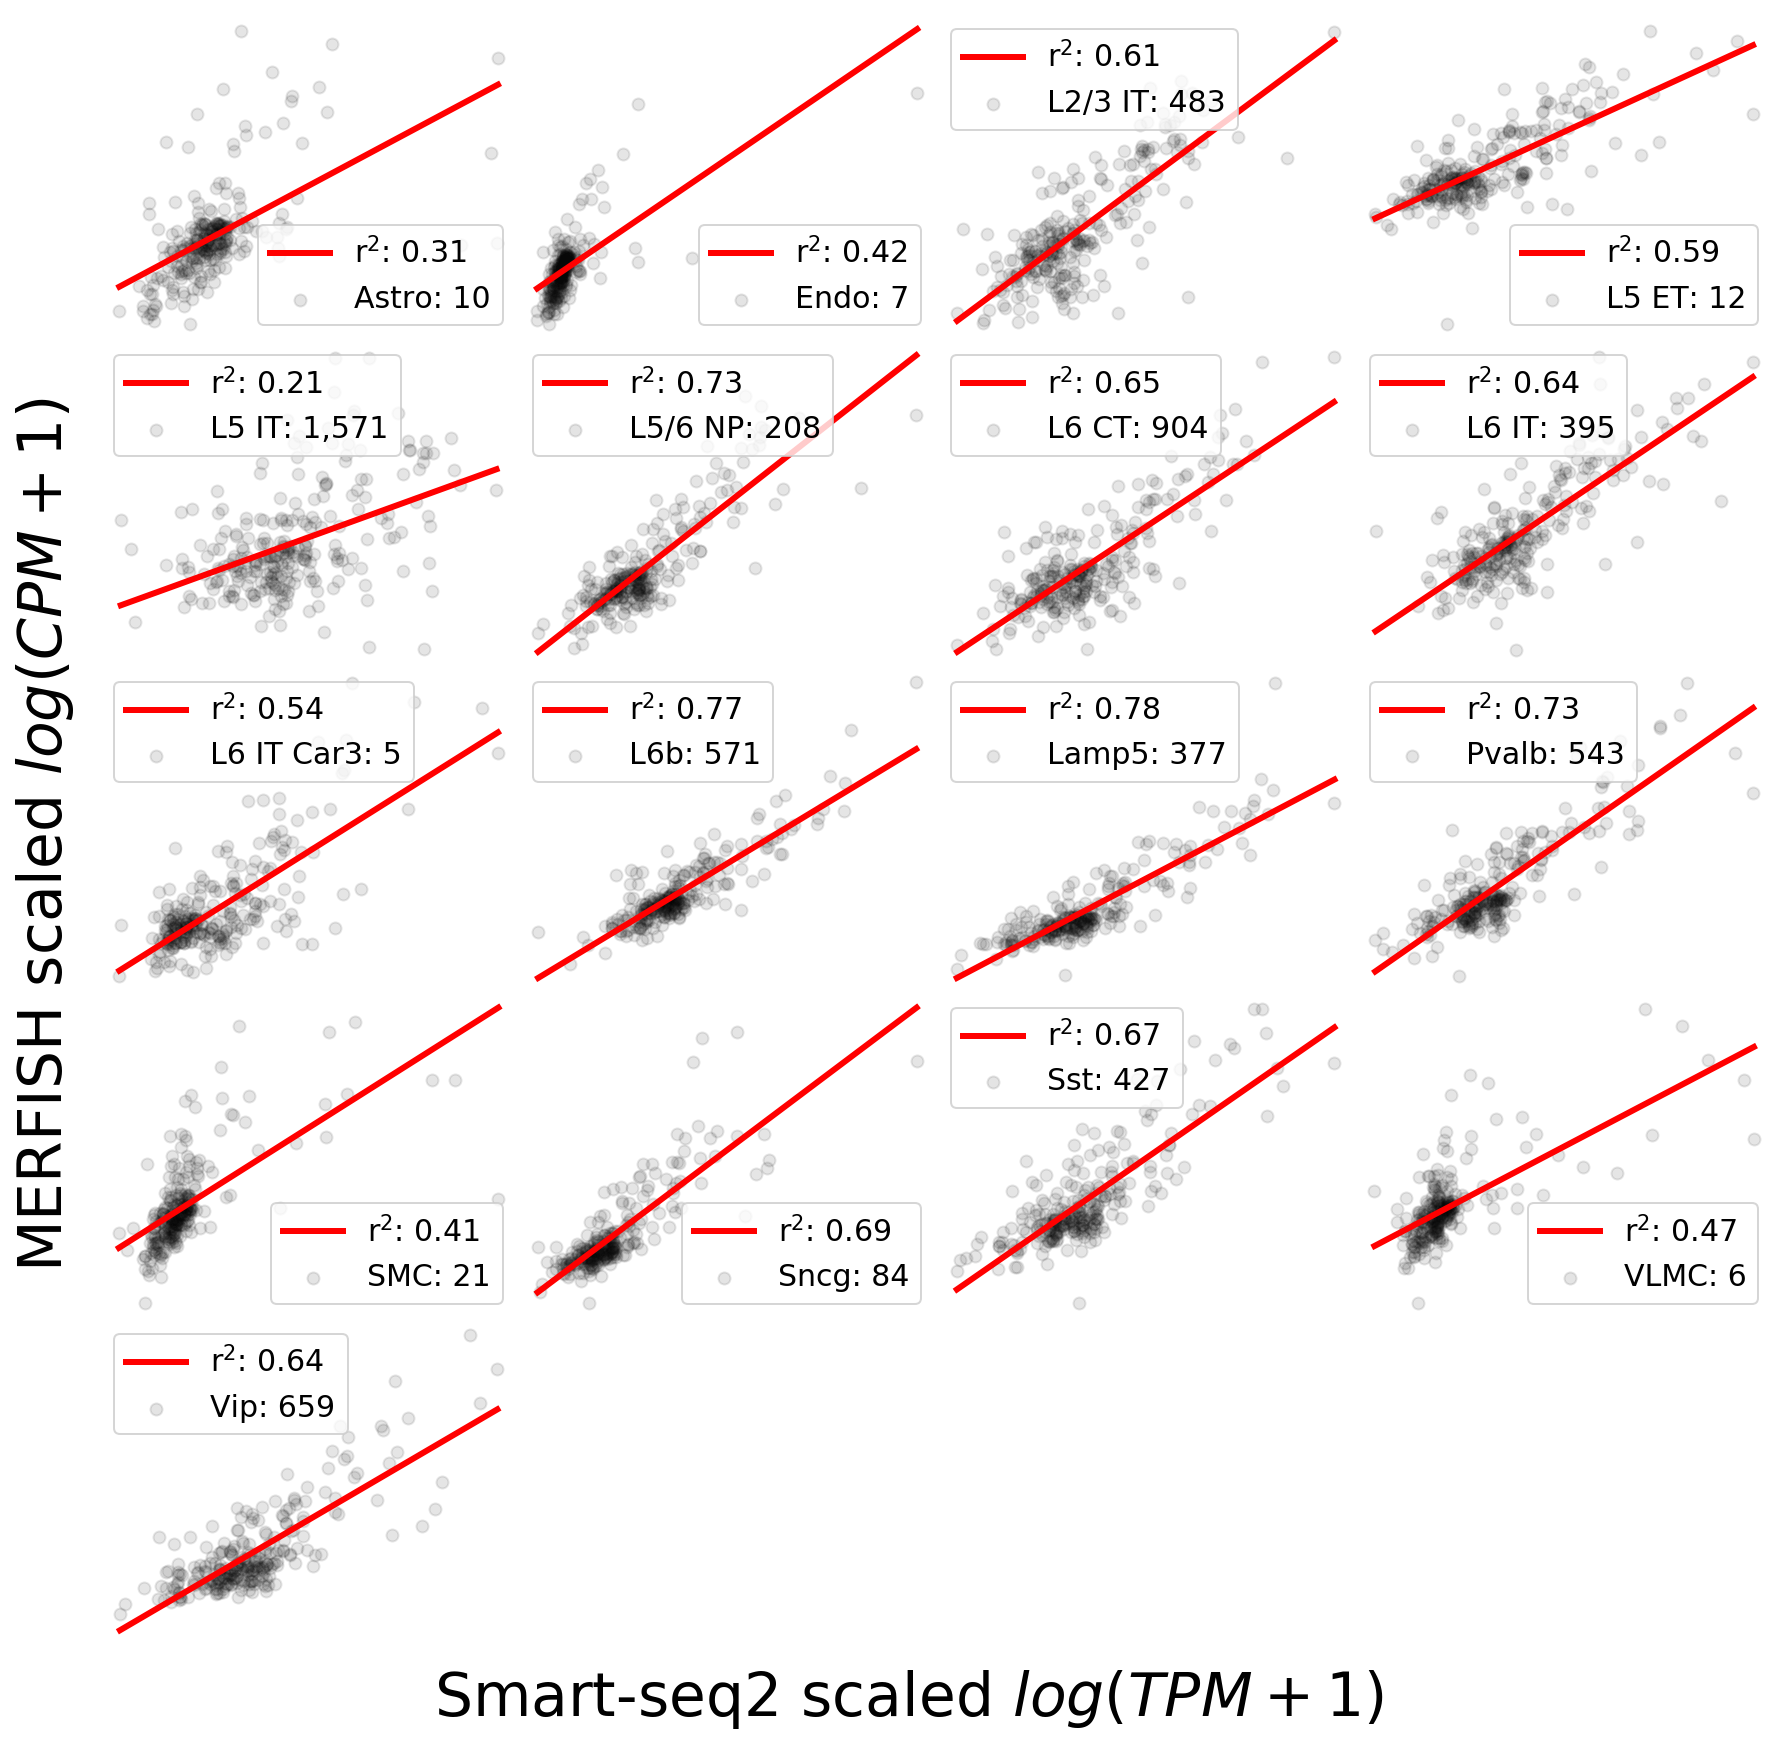

In [123]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = mfish_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="r$^2$: {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
fig.text(0.5, 0.1, 'Smart-seq2 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'MERFISH scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("./figures/merfish_correlation_scatter.png", bbox_inches='tight',dpi=300)

plt.show()